In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ddsm-mammography/cv10_labels.npy
/kaggle/input/ddsm-mammography/test10_labels.npy
/kaggle/input/ddsm-mammography/training10_1/training10_1.tfrecords
/kaggle/input/ddsm-mammography/cv10_data/cv10_data.npy
/kaggle/input/ddsm-mammography/test10_data/test10_data.npy
/kaggle/input/ddsm-mammography/training10_3/training10_3.tfrecords
/kaggle/input/ddsm-mammography/training10_2/training10_2.tfrecords
/kaggle/input/ddsm-mammography/training10_0/training10_0.tfrecords
/kaggle/input/ddsm-mammography/training10_4/training10_4.tfrecords


In [2]:
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from collections import Counter
import IPython.display as display

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier # XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import MinMaxScaler,LabelBinarizer
from sklearn.ensemble import AdaBoostClassifier # AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier # KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # RandomForestClassifier
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print('hi')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


hi


In [3]:
images=[]
labels=[]
feature_dictionary = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'label_normal': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
    }

In [4]:
def _parse_function(example, feature_dictionary=feature_dictionary):
    parsed_example = tf.io.parse_example(example, feature_dictionary)
#     print('feature_dictionary[label]',feature_dictionary['label'])
    return parsed_example

def read_data(filename):
    full_dataset = tf.data.TFRecordDataset(filename,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    full_dataset = full_dataset.shuffle(buffer_size=31000)
    full_dataset = full_dataset.cache()
    print("Size of Training Dataset: ", len(list(full_dataset)))
    count = 0

    full_dataset = full_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    for image_features in full_dataset:
        count += 1
        image = image_features['image'].numpy()
        image = tf.io.decode_raw(image_features['image'], tf.uint8)
        image = tf.reshape(image, [299, 299])        
        image=image.numpy()
        image=cv2.resize(image,(100,100))
        image=cv2.merge([image,image,image])        
        images.append(image)
        labels.append(image_features['label_normal'].numpy())


In [5]:
filenames=['../input/ddsm-mammography/training10_0/training10_0.tfrecords',
          '../input/ddsm-mammography/training10_1/training10_1.tfrecords',
          '../input/ddsm-mammography/training10_2/training10_2.tfrecords',
          '../input/ddsm-mammography/training10_3/training10_3.tfrecords',
          '../input/ddsm-mammography/training10_4/training10_4.tfrecords']

for file in filenames:
    read_data(file)
    
print(len(images))
print(len(labels))

Size of Training Dataset:  11177
Size of Training Dataset:  11177
Size of Training Dataset:  11177
Size of Training Dataset:  11177
Size of Training Dataset:  11177
55885
55885


In [6]:
print(sum(labels))

7289


In [7]:
X=np.array(images)
y=np.array(labels)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021,shuffle=True,stratify=y)

In [8]:
print(x_train.shape, y_train.shape)
print(sum(y_train))

(44708, 100, 100, 3) (44708,)
5831


In [9]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train.reshape((-1, 100 * 100 * 3)), y_train)
x_train_resampled = x_train_resampled.reshape((-1, 100, 100, 3))


In [10]:
print(x_train_resampled.shape, y_train_resampled.shape) #33046 new images added
print(sum(y_train_resampled)) #seems balanced , 38877 = 1's & 38877 are 0's 

(77754, 100, 100, 3) (77754,)
38877


### Defining Resnet50 Model:

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
train_datagen = ImageDataGenerator(rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   fill_mode = 'nearest'
                                   ) 
train_data_augmented = train_datagen.flow(x_train, y_train, batch_size = 128)

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

#defining my_model architecture 
base_model = ResNet50(input_shape=(100,100,3), weights='imagenet', include_top=False)
my_model=Sequential()
my_model.add(base_model)
my_model.add(Dropout(0.2))
my_model.add(Flatten())
my_model.add(BatchNormalization())
my_model.add(Dense(1024, kernel_regularizer=l2(0.001)))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(Dropout(0.2))
my_model.add(Dense(1024,kernel_regularizer=l2(0.001)))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(Dropout(0.2))
my_model.add(Dense(1024,kernel_regularizer= l2(0.001)))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(Dropout(0.2))
my_model.add(Dense(1024,kernel_regularizer=l2(0.001)))
my_model.add(BatchNormalization())
my_model.add(Activation('relu'))
my_model.add(Dropout(0.2))
my_model.add(Dense(1, activation = 'sigmoid'))
my_model.layers[0].trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [13]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 batch_normalization (Batch  (None, 32768)             131072    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                       

In [14]:
#implementing callbacks: 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)

In [15]:
#compiling and fitting the model : 
from tensorflow.keras.optimizers import SGD
my_model.compile(
    optimizer=SGD(learning_rate=0.001), #changing lr from 0.001 to ...
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)
# Assuming binary classification and y_train contains labels
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weight_dict = dict(enumerate(class_weights))
class_weight_dict = {0: 1,   # Majority class weight
                     1: 5}   # Minority class weight

history = my_model.fit(x_train_resampled, y_train_resampled,
                       validation_split=0.2,
#                        class_weight=class_weight_dict,
                       shuffle=True,
                       epochs=100,
                       batch_size=128,
                       callbacks=[early_stopping, reduce_lr])

loss_value , accuracy = my_model.evaluate(x_test, y_test)

print('Test_loss_value = ' + str(loss_value))
print('test_accuracy = ' + str(accuracy))

Epoch 1/100


2023-11-16 02:55:36.399578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


486/486 [==============================] - 55s 87ms/step - loss: 5.5969 - accuracy: 0.7210 - val_loss: 5.4627 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 2/100
486/486 [==============================] - 38s 79ms/step - loss: 5.4782 - accuracy: 0.7934 - val_loss: 5.4027 - val_accuracy: 0.8515 - lr: 0.0010
Epoch 3/100
486/486 [==============================] - 38s 79ms/step - loss: 5.4314 - accuracy: 0.8153 - val_loss: 5.3577 - val_accuracy: 0.8684 - lr: 0.0010
Epoch 4/100
486/486 [==============================] - 38s 79ms/step - loss: 5.3968 - accuracy: 0.8277 - val_loss: 5.3305 - val_accuracy: 0.8768 - lr: 0.0010
Epoch 5/100
486/486 [==============================] - 38s 79ms/step - loss: 5.3685 - accuracy: 0.8374 - val_loss: 5.2944 - val_accuracy: 0.8895 - lr: 0.0010
Epoch 6/100
486/486 [==============================] - 38s 79ms/step - loss: 5.3420 - accuracy: 0.8468 - val_loss: 5.2703 - val_accuracy: 0.8996 - lr: 0.0010
Epoch 7/100
486/486 [==============================] - 38s 79ms/

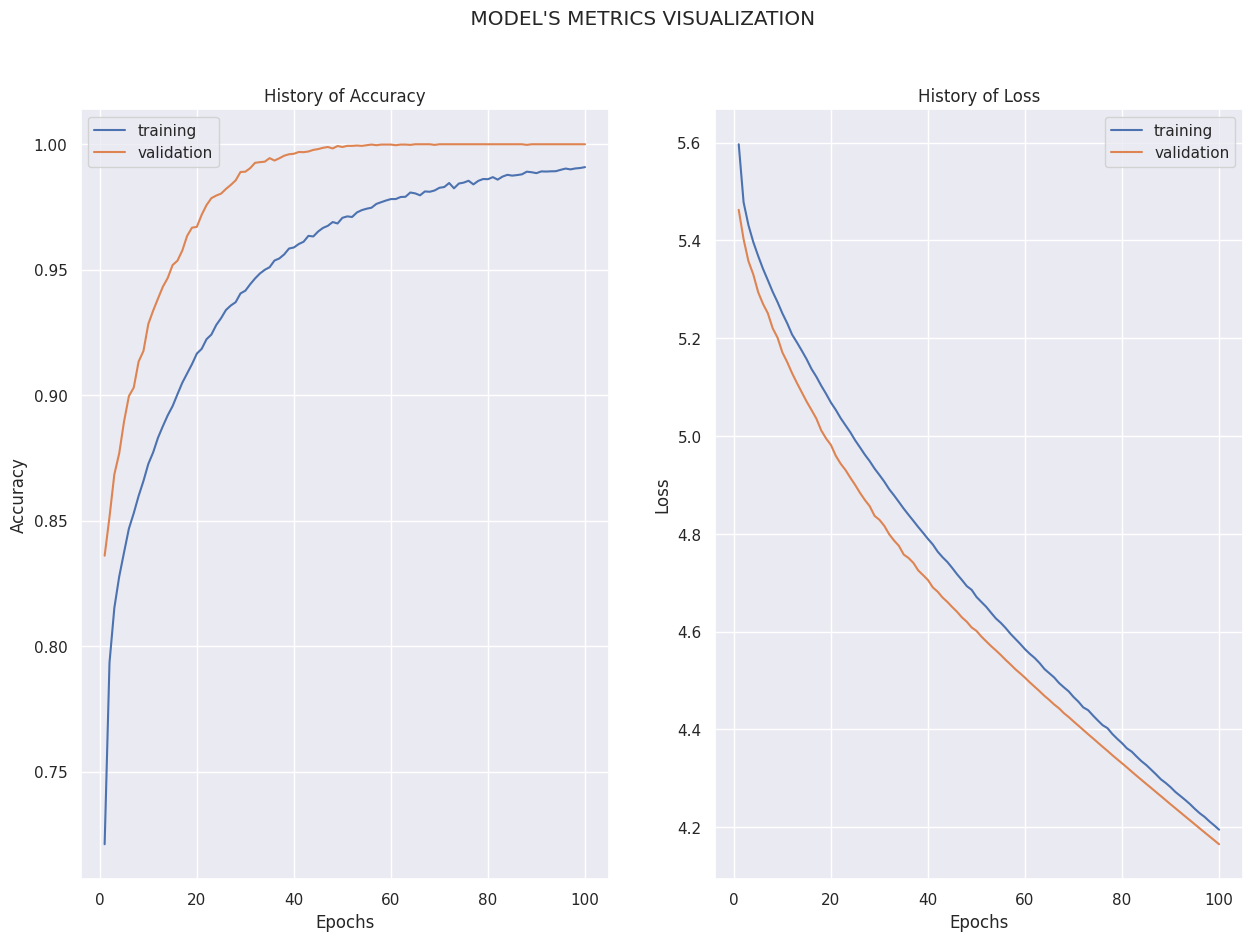

In [16]:
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [29]:
y_pred_probs = my_model.predict(x_test)
threshold = 0.2 
y_pred = (y_pred_probs > threshold).astype(int)
target=["0","1"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
# print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

350/350 [==============================] - 7s 19ms/step
Accuracy: 0.9139
Precision: 0.9285
Recall: 0.9139
F1 Score: 0.9189
Cohen Kappa Score: 0.6665
		Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      9719
           1       0.63      0.83      0.72      1458

    accuracy                           0.91     11177
   macro avg       0.80      0.88      0.83     11177
weighted avg       0.93      0.91      0.92     11177



### Training Model on unseen data: 

In [20]:
import numpy as np

cv_data = np.load('/kaggle/input/ddsm-mammography/cv10_data/cv10_data.npy')
test_data = np.load('/kaggle/input/ddsm-mammography/test10_data/test10_data.npy')

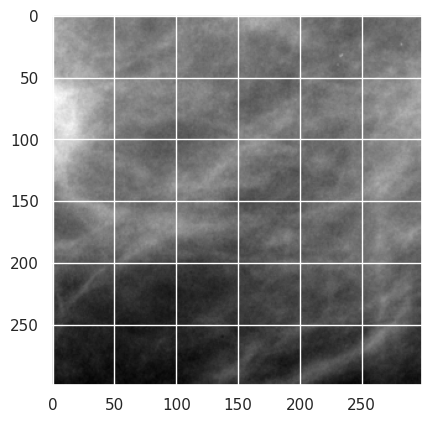

In [21]:
#tryign to visualize a few images:
import matplotlib.pyplot as plt

plt.imshow(cv_data[1].squeeze(), cmap='gray')
plt.show()


In [22]:
cv_labels = np.load('/kaggle/input/ddsm-mammography/cv10_labels.npy')
test_data_labels = np.load('/kaggle/input/ddsm-mammography/test10_labels.npy')
print(cv_labels.shape, test_data_labels.shape)

(7682,) (7682,)


In [23]:
cv_labels_binary = np.where(cv_labels > 2, 1, 0)
test_data_labels_binary = np.where(test_data_labels > 2, 1, 0)
set(cv_labels_binary) #0,1
set(test_data_labels_binary) #0, 1

{0, 1}

In [24]:
import numpy as np
import tensorflow as tf

# Function to resize and convert 1-channel grayscale images to 3-channel RGB images
def preprocess_images(images, new_size=(100, 100)):
    processed_images = []

    for img in images:
        # Resize image
        resized_img = tf.image.resize(img, new_size)

        # Convert to 3-channel RGB by replicating the single channel
        rgb_img = tf.repeat(resized_img, 3, axis=-1)

        processed_images.append(rgb_img)

    return np.array(processed_images)

# Preprocess cv_data
cv_data_processed = preprocess_images(cv_data)
test_data_processed = preprocess_images(test_data)
print(cv_data_processed.shape, test_data_processed.shape)

(7682, 100, 100, 3) (7682, 100, 100, 3)


In [32]:
y_pred_cvdata = my_model.predict(cv_data_processed)
threshold = 0.2  # Example threshold, adjust based on your requirements
cv_data_pred = (y_pred_cvdata > threshold).astype(int)
target=["0","1"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(cv_labels_binary, cv_data_pred),4))
print('Precision:', np.round(metrics.precision_score(cv_labels_binary, cv_data_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(cv_labels_binary,cv_data_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(cv_labels_binary, cv_data_pred, average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(cv_labels_binary, cv_data_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(cv_labels_binary, cv_data_pred,target_names=target))

241/241 [==============================] - 5s 19ms/step
Accuracy: 0.8861
Precision: 0.9467
Recall: 0.8861
F1 Score: 0.9089
Cohen Kappa Score: 0.3591
		Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.94      7274
           1       0.28      0.74      0.41       408

    accuracy                           0.89      7682
   macro avg       0.63      0.82      0.67      7682
weighted avg       0.95      0.89      0.91      7682



In [33]:
y_pred_testdata = my_model.predict(test_data_processed)
threshold = 0.2  
test_data_pred = (y_pred_testdata > threshold).astype(int)
#measuring accuracy : 
target=["0","1"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(test_data_labels_binary, test_data_pred),4))
print('Precision:', np.round(metrics.precision_score(test_data_labels_binary, test_data_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(test_data_labels_binary,test_data_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(test_data_labels_binary, test_data_pred, average='weighted'),4))
# print('ROC AUC Score:', np.round(metrics.roc_auc_score(test_data_labels_binary, test_data_pred_prb,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(test_data_labels_binary, test_data_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(test_data_labels_binary, test_data_pred,target_names=target))

241/241 [==============================] - 5s 20ms/step
Accuracy: 0.8849
Precision: 0.9592
Recall: 0.8849
F1 Score: 0.9108
Cohen Kappa Score: 0.4054
		Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94      7286
           1       0.30      0.92      0.45       396

    accuracy                           0.88      7682
   macro avg       0.65      0.90      0.69      7682
weighted avg       0.96      0.88      0.91      7682



In [28]:
my_model.save_weights('balanced_cancer_classification_weights.h5')
